In [1]:
from PIL import Image

# Try opening the content image
try:
    img = Image.open("content.jpg")
    img.show()  # Only works locally, not in Colab, but should not error
    print("✅ content.jpg loaded successfully!")
except Exception as e:
    print("❌ content.jpg failed to load:", e)

# Try opening the style image
try:
    img = Image.open("style.jpg")
    print("✅ style.jpg loaded successfully!")
except Exception as e:
    print("❌ style.jpg failed to load:", e)


✅ content.jpg loaded successfully!
✅ style.jpg loaded successfully!


In [2]:
!pip install torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 844.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [3]:
def load_image(img_path, max_size=400):
    image = Image.open(img_path).convert('RGB')
    size = min(max(image.size), max_size)

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor()
    ])

    image = transform(image)[:3, :, :].unsqueeze(0)
    return image.to(torch.float)


In [4]:
content = load_image("content.jpg")
style = load_image("style.jpg")


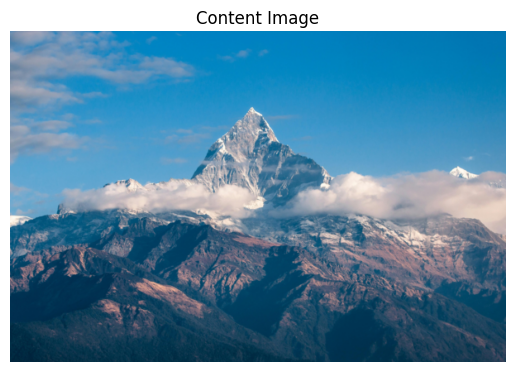

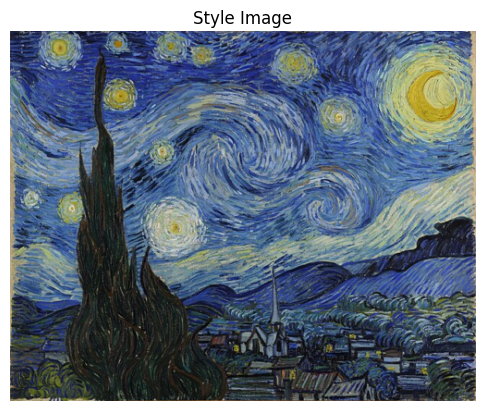

In [5]:
def imshow(tensor, title=None):
    image = tensor.clone().detach().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Show both images
imshow(content, title='Content Image')
imshow(style, title='Style Image')



In [6]:
vgg = models.vgg19(pretrained=True).features

# Freeze model parameters
for param in vgg.parameters():
    param.requires_grad_(False)

# Move model and images to device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
content = content.to(device)
style = style.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 76.3MB/s]


In [7]:
# Get features from layers
def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  # content layer
            '28': 'conv5_1'
        }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Style: Gram Matrix
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


In [8]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create the target image to be updated
target = content.clone().requires_grad_(True).to(device)


In [9]:
# Set weights
style_weight = 1e6
content_weight = 1

# Optimizer
optimizer = optim.Adam([target], lr=0.003)

# Training loop
for step in range(1, 201):
    target_features = get_features(target, vgg)

    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_features:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_loss = torch.mean((target_gram - style_gram)**2)
        b, c, h, w = target_feature.shape
        style_loss += layer_loss / (c * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step}, Total loss: {total_loss.item():.2f}")


Step 50, Total loss: 2781246.75
Step 100, Total loss: 1639985.00
Step 150, Total loss: 1171823.25
Step 200, Total loss: 926011.12


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


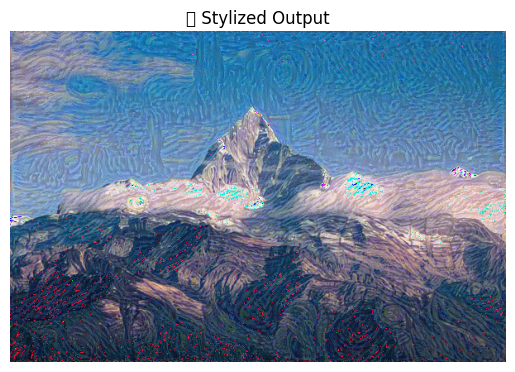

In [10]:
imshow(target, title="🎨 Stylized Output")
